* Double DQN
* prioritized ER 
* gradient clipping
* 3 layers, 50 hidden dim
* $\gamma = 0.99$
* activation is softplus
* batch normalization
* optimizer is Adam and learning rate is 0.001
* the loss is the MSE (Bellman) + a penalty for going outside of (-RMAX, RMAX)
* maximum 8-10 steps of optimization for finding $argmax_{a}Q(s,a)$ with Rprop algorithm
* actions are logged. As some can be zero, we replace the zeros by the minimal action taken


In this notebook, we feed the memory little by little.

This is because we think that the rareness of -15 transitions prevents the model from learning

In [2]:
print('ready')

ready


In [3]:
import torch as t
from torch.nn import ReLU, SELU, LeakyReLU
import numpy as np
from random import random, sample
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from IPython import display
from parse_dataset import *
from icnn import ICNN, ICNNBN, gradient_step_action, diff_params, loss_beyond_RMAX, clip_gradients, get_q_target, update_parameters_lag
from copy import deepcopy
from utils import variable, moving_avg
from replay_buffer import PrioritizedReplayBuffer

# Load and parse dataset

In [4]:
data = pd.read_csv('Sepsis_imp.csv')
replace_absurd_temperatures(data)
data = drop_patients_with_absurd_weights(data)
data = drop_patients_with_unrealistic_HR_or_BP(data)
data = add_relative_time_column(data)
data = drop_patient_with_negative_input(data)
add_small_quantities(data)
create_action_column(data)
add_log_actions(data)

log_scaler = StandardScaler()
scaler = StandardScaler()
action_scaler = StandardScaler()
train_idx, test_idx = split_train_test_idx(data)

# scale on train data only
scaler.fit(data.loc[data.icustayid.isin(train_idx)][numerical_columns_not_to_be_logged])
log_scaler.fit(np.log(data.loc[data.icustayid.isin(train_idx)][numerical_columns_to_be_logged]))
action_scaler.fit(data.loc[data.icustayid.isin(train_idx)][log_action_cols])

StandardScaler(copy=True, with_mean=True, with_std=True)

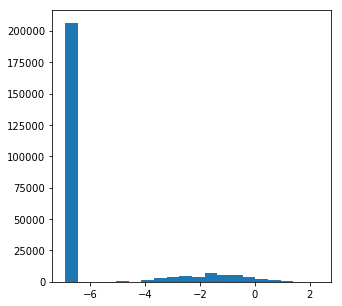

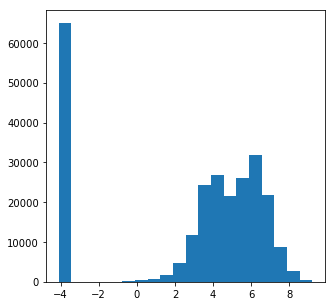

In [5]:
plt.rcParams['figure.figsize'] = (5,5)
plt.hist(data.log_vaso, bins=20)
plt.show()
plt.hist(data.log_fluid, bins=20)
plt.show()

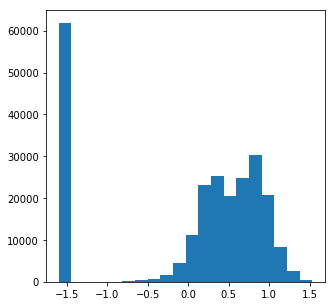

In [6]:
plt.hist(action_scaler.transform(data.loc[data.icustayid.isin(train_idx)][log_action_cols])[:,1], bins=20)
plt.show()

Split train/test

In [7]:
train_idx, test_idx = split_train_test_idx(data)

List of transitions `(s,a,r,s')`

In [8]:
transitions_train = transition_iterator(data, train_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

C:\Users\sebastien\anaconda_notebook\cs282-f17-sebastian-camilo\parse_dataset.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx == None:


In [9]:
transitions_test = transition_iterator(data, test_idx, scaler, log_scaler, action_scaler, RMAX=15, log_action=True)

C:\Users\sebastien\anaconda_notebook\cs282-f17-sebastian-camilo\parse_dataset.py:264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if idx == None:


In [10]:
transitions_dict = {k: {
    "s": values[0],
    "a": values[1],
    "r": values[2],
    "s'": values[3]   
}
 for k, values in enumerate(transitions_train)
}

Compute bounds for the actions (you don't have right to prescribe less than the min or more than the max). It gives bounds to the possible actions and ensure that the max of Q can actually be found

In [11]:
min0 = min([d['a'][0] for k, d in transitions_dict.items()])
max0 = max([d['a'][0] for k, d in transitions_dict.items()])
min1 = min([d['a'][1] for k, d in transitions_dict.items()])
max1 = max([d['a'][1] for k, d in transitions_dict.items()])

### Build neural network
The neural network is convex in $a$

$$u_0 = s$$
$$z_0 = a$$
$$u_{i+1} = \tilde{g}_i(\tilde{W}_iu_i+b_i)$$
$$z_{i+1} = g_i\left(W_i^{(z)}(z_i \cdot (W_i^{(zu)}u_i+b_i^{(z)})_+) + W_i^{(a)}(a \cdot (W_i^{(au)}u_i+b_i^{(a)})) + W_i^{(u)}u_i+b_i\right)$$
with $$W_i^{(z)}\geq 0$$


In [12]:
# Q_select = ICNN(3, 50, activation=SELU())
Q_select = ICNNBN(3, 50, LeakyReLU(-1.))
Q_eval = deepcopy(Q_select)
Q_eval.eval()

ICNNBN (
  (activation): Softplus (beta=1, threshold=20)
  (u0): Linear (50 -> 50)
  (bn_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (u1): Linear (50 -> 50)
  (bn_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u0): Linear (50 -> 50)
  (bn_z_u0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au0): Linear (50 -> 2)
  (bn_z_au0): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_0): Linear (2 -> 50)
  (bn_z_au_0): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_u1): Linear (50 -> 50)
  (bn_z_u1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_au1): Linear (50 -> 2)
  (bn_z_au1): BatchNorm1d(2, eps=0.001, momentum=0.99, affine=True)
  (z_au_1): Linear (2 -> 50)
  (bn_z_au_1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu1): Linear (50 -> 50)
  (bn_z_zu1): BatchNorm1d(50, eps=0.001, momentum=0.99, affine=True)
  (z_zu_1): Linear (50 -> 50)
  (bn_z_zu_1): BatchNorm1d(50, eps=0.001, momentu

In [13]:
print('#params: %s' % np.sum([np.prod(p.data.numpy().shape) for p in Q_select.parameters()]))

#params: 19327


# Get PER

In [14]:
# CREATE PRIORITIZED ER EXPERIENCE BUFFER
memory = PrioritizedReplayBuffer(len(transitions_dict), .6)
n_initial_0 = 500  # this is the initial number of transitions having reward 0
n_initial_15 = 1000  # this is the initial number of transitions having reward 15
n_initial_m15 = 5000  # this is the initial number of transitions having reward -15
count_15 = 0
count_0 = 0
count_m15 = 0

saved = set()
for idx, tr in shuffle(list(transitions_dict.items())):
    save = False
    if tr['r'] == 0 and count_0 < n_initial_0:
        count_0 += 1
        save = True
    if tr['r'] == -15 and count_m15 < n_initial_m15:
        count_m15 += 1
        save = True
    if tr['r'] == 15 and count_15 < n_initial_15:
        count_15 += 1
        save = True
    
    if save:
        saved.add(idx)
        # check if state is terminal
        if tr["s'"] is not None:
            s_ = tr["s'"]
            done = False
        else:
            s_ = np.array(50*[np.nan])
            done = True
        s = tr['s']
        a = tr['a']
        r = np.array([tr['r']])

        transition = (s,a,r,s_,done)
        memory.add(*transition)

In [15]:
not_present_yet = shuffle([k for k in transitions_dict if k not in saved])

# Train model

In [16]:
print('ready')

ready


In [17]:
def clip(x):
    """
    Clip values below -RMAX or above RMAX
    Might be useful when the target goes beyond
    """
    return x*((x>=-RMAX).float())*((x<=RMAX).float()) + RMAX*(x>RMAX).float() - RMAX*(x<-RMAX).float()

In [18]:
def test():
    n = len(transitions_test)
    for i in range(0, len(transitions_test), batch_size):
        transitions = transitions_test[i:i+batch_size]
        s = t.cat([variable(tr[0].reshape((1,50))) for tr in transitions])
        a = t.cat([variable(tr[1].reshape((1,2))) for tr in transitions])
        r = t.cat([variable(tr[2].reshape((1,1))) for tr in transitions])
        s_ = t.cat([variable(tr[3].reshape((1,50))) if tr[3] is not None else variable(np.array([50*[np.nan]])) for tr in transitions])
        Q_select.eval()
        pred = Q_select.forward(s, a).squeeze()  # Q(s, a)
        target, max_actions = get_q_target(Q_select, Q_eval, s_, r, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)
        Q_select.train()
        target = target.squeeze()
        if i == 0:
            td_error = t.sum(t.abs(pred-target))
            avg_Q = t.sum(pred)
            max_Q = t.max(pred)
            min_Q = t.min(pred)
        else:
            td_error += t.sum(t.abs(pred-target))
            avg_Q += t.sum(pred)
            max_Q += t.max(pred)
            min_Q += t.min(pred)
    return td_error.data.numpy()[0]/n, avg_Q.data.numpy()[0]/n, max_Q.data.numpy()[0]/(n/batch_size), min_Q.data.numpy()[0]/(n/batch_size)
        

# Idees
* lag update ?
* commencer avec une proportion egale de +15, -15, 0, et ajouter des 0 a chaque batch
* ajouter un terme dans la loss pour penaliser les valeurs extremes, avec une loss ressemblant a $(Q(s, \alpha) + 15)^2$ avec $\alpha$ le max des vasos par exemple


In [20]:
def get_q_target(Q_select, Q_eval, next_state, rewards, min0, max0, min1, max1, gamma=1., max_steps_a=5, return_max_actions=False):
    next_state_ = []
    good = dict()
    for i, s in enumerate(next_state):
        if not np.isnan(s.data.numpy()[0]):
            next_state_.append(s.resize(1, 50))
            good[i] = len(good)
    if len(good) == 0:
        return rewards.squeeze(), variable(np.array(len(rewards)*[[np.nan, np.nan]]))
    else:
        next_state_ = t.cat(next_state_)
        max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
        prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
        input_param = t.nn.Parameter(max_action.data)
        optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
        for k in range(max_steps_a):
            max_action, input_param, optimizer_for_a = gradient_step_action(Q_select, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
            if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
                break
            prev_action = max_action * 1

        pred = Q_eval.forward(next_state_, max_action)
        Qvalues = [pred[good[i]].float().resize(1, 1) if i in good else variable(np.zeros((1, 1))).float() for i in range(len(next_state))]
        max_prev_Q_value = t.cat(Qvalues, dim=0)
        Q_target = rewards.squeeze() + gamma * max_prev_Q_value.squeeze()
        if not return_max_actions:
            return Q_target
        else:
            return Q_target, max_action

In [21]:
from time import time
plt.rcParams['figure.figsize'] = (20,20)

# RL parameters
global_step = -1
EPOCHS = 100
gamma = .99
max_steps_beta = 100000
beta0 = .4
beta = lambda t: (t<max_steps_beta)*(beta0 + t*(1-beta0)/max_steps_beta) + (t>=max_steps_beta)*1.
RMAX = 15
c = 1e4
T_UPDATE = 200  # parameter to copy the weights periodically

# OPTIMIZER PARAMETERS
batch_size = 32
learning_rate = 1e-3  # can have higher than default value if use BatchNorm
optimizer = t.optim.Adam(Q_select.parameters(), lr=learning_rate)
max_steps = int(len(data) / batch_size)
max_steps_a = 8

# monitoring
losses = []
td_errors = []
test_td_errors = []
test_average_q_pred = []
test_max_q_pred = []
test_min_q_pred = []
average_q_pred = []
average_q_target = []
max_q_pred = []
min_q_pred = []
max_q_target = []
min_q_target = []
average_vaso = []
max_vaso = []
min_vaso = []
average_fluid = []
max_fluid = []
min_fluid = []


# TRAIN
for _ in range(EPOCHS):
    t0 = time()
    for step in range(max_steps):
        global_step += 1

        # Add transition in memory
        idx = not_present_yet.pop()
        tr = transitions_dict[idx]
        if tr["s'"] is not None:
            s_ = tr["s'"]
            done = False
        else:
            s_ = np.array(50*[np.nan])
            done = True
        s = tr['s']
        a = tr['a']
        r = np.array([tr['r']])
        transition = (s,a,r,s_,done)
        memory.add(*transition)
        
        # Sample batch
        s,a,r,s_,done,w,idx = memory.sample(batch_size, beta(global_step))
        states = variable(s)
        actions = variable(a)
        rewards = variable(r)
        next_states = variable(s_)
        weights = variable(w).squeeze()
        
        # Init grad (set all of them to zero)
        optimizer.zero_grad()

        # Compute loss
        pred = Q_select.forward(states, actions).squeeze()  # Q(s, a)
        Q_select.eval()
        target, max_actions = get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)
        Q_select.train()
        target = clip(target.squeeze())
        loss = (pred-target)
        loss = loss**2
        loss = loss*weights  # multiplication by the PER coefficients
        loss = t.mean(loss) + c*t.mean(loss_beyond_RMAX(pred, RMAX))
        
        # Update priorities
        td_error = t.abs(pred - target) + 1e-3
        memory.update_priorities(idx, td_error.data.numpy())
        
        # Monitoring
        losses.append(loss.data.numpy()[0])
        td_errors.append(td_error.data.numpy().mean())
        average_q_pred.append(t.mean(pred).squeeze().data.numpy()[0])
        max_q_pred.append(t.max(pred).squeeze().data.numpy()[0])
        min_q_pred.append(t.min(pred).squeeze().data.numpy()[0])
        average_q_target.append(t.mean(target).squeeze().data.numpy()[0])
        max_q_target.append(t.max(target).squeeze().data.numpy()[0])
        min_q_target.append(t.min(target).squeeze().data.numpy()[0])
        min_a = np.min(max_actions.data.numpy(), 0).squeeze()
        max_a = np.max(max_actions.data.numpy(), 0).squeeze()
        mean_a = np.mean(max_actions.data.numpy(), 0).squeeze()
        min_vaso.append(min_a[0])
        max_vaso.append(max_a[0])
        average_vaso.append(mean_a[0])
        min_fluid.append(min_a[1])
        max_fluid.append(max_a[1])
        average_fluid.append(mean_a[1])
        
        # Compute gradients and update weights of the selection network
        loss.backward()
        clip_gradients(Q_select, 10)
        optimizer.step()
        
        # Keep weights positive so that the Q_select stays concave
        Q_select.proj()
        
        # update parameters of the evaluation network. Its weights lag behind
        if global_step % T_UPDATE == 0:
            Q_eval = deepcopy(Q_select)
            Q_eval.eval()

        # PLOT
        if step % 250 == 0:
            display.clear_output(wait=True)
            
            fig, axes = plt.subplots(3, 2)
            # td error
            axes[0,0].plot(moving_avg(losses))
            axes[0,1].plot(moving_avg(td_errors))
            # Q values (target and pred)
            axes[1,0].plot(moving_avg(average_q_pred), label='avg pred', c='darkblue')
            axes[1,0].plot(moving_avg(min_q_pred), label='min pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(max_q_pred), label='max pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(average_q_target), label='avg target', c='crimson')
            axes[1,0].plot(moving_avg(min_q_target), label='min target', c='crimson', alpha=.8,linestyle=':')
            axes[1,0].plot(moving_avg(max_q_target), label='max target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(average_q_pred[200:]), label='avg pred', c='darkblue')
            axes[1,1].plot(moving_avg(min_q_pred[200:]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(max_q_pred[200:]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(average_q_target[200:]), label='avg target', c='crimson')
            axes[1,1].plot(moving_avg(min_q_target[200:]), label='min target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].plot(moving_avg(max_q_target[200:]), label='max target', c='crimson', alpha=.8,linestyle=':')
            axes[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            # actions (vaso and fluid)
            axes[2,0].plot(moving_avg(average_fluid), label='avg fluid', c='darkblue')
            axes[2,0].plot(moving_avg(min_fluid), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(max_fluid), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(average_vaso), label='avg vaso', c='crimson')
            axes[2,0].plot(moving_avg(min_vaso), label='min vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,0].plot(moving_avg(max_vaso), label='max vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(average_fluid[200:]), label='avg fluid', c='darkblue')
            axes[2,1].plot(moving_avg(min_fluid[200:]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(max_fluid[200:]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(average_vaso[200:]), label='avg vaso', c='crimson')
            axes[2,1].plot(moving_avg(min_vaso[200:]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].plot(moving_avg(max_vaso[200:]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
            axes[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
            plt.tight_layout()
            plt.show()
            
            print('Epoch %s\n%s steps in this epoch\n%s steps/s' % (str(_), str(step), str(step/(time()-t0))))

KeyboardInterrupt: 

In [2]:
import os
os.path.join('tensorboard', 'models/6000')

'tensorboard\\models/6000'

In [22]:
pred

Variable containing:
 -9.4549
  9.0465
 12.2210
 11.6398
 -7.4161
 11.2829
  6.3840
 -5.1809
  9.3233
  9.3063
 -5.1453
 -8.3277
 -7.0646
 -6.3603
 -9.0721
  7.4978
  9.4080
 -4.4689
 10.1877
 15.1662
  9.1227
 -8.8364
 -5.3155
  1.7906
-12.7779
 16.4919
-11.4033
 -2.4583
 -6.7034
 -1.6795
 16.1003
 10.6520
[torch.FloatTensor of size 32]

In [ ]:
t.mean((pred-target)**2)

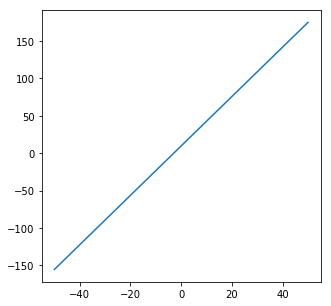

In [38]:
plt.rcParams['figure.figsize']=(5,5)
a, b = -50, 50
state = variable(np.concatenate(100*[np.random.normal(size=(1,50))], 0)).float()
actions = variable(np.array([[aa,0] for aa in np.linspace(a,b,100)])).float()
Q_select.eval()
Qvalues = Q_select.forward(state, actions).data.numpy()
plt.plot(np.linspace(a,b,100), Qvalues)
plt.show()

# Graphs

In [ ]:
fig, axes = plt.subplots(3, 2)
plt.rcParams['figure.figsize'] = (20,20)
# td error
axes[0,0].plot(moving_avg(np.log(losses[:5000])))
# Q values (target and pred)
axes[1,0].plot(moving_avg(average_q_pred[:5000]), label='avg pred', c='darkblue')
axes[1,0].plot(moving_avg(min_q_pred[:5000]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(max_q_pred[:5000]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(average_q_target[:5000]), label='avg target', c='crimson')
axes[1,0].plot(moving_avg(min_q_target[:5000]), label='min target', c='crimson', alpha=.8,linestyle=':')
axes[1,0].plot(moving_avg(max_q_target[:5000]), label='max target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(average_q_pred[200:5000]), label='avg pred', c='darkblue')
axes[1,1].plot(moving_avg(min_q_pred[200:5000]), label='min pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(max_q_pred[200:5000]), label='max pred', c='darkblue', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(average_q_target[200:5000]), label='avg target', c='crimson')
axes[1,1].plot(moving_avg(min_q_target[200:5000]), label='min target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].plot(moving_avg(max_q_target[200:5000]), label='max target', c='crimson', alpha=.8,linestyle=':')
axes[1,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
# actions (vaso and fluid)
axes[2,0].plot(moving_avg(average_fluid[:5000]), label='avg fluid', c='darkblue')
axes[2,0].plot(moving_avg(min_fluid[:5000]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(max_fluid[:5000]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(average_vaso[:5000]), label='avg vaso', c='crimson')
axes[2,0].plot(moving_avg(min_vaso[:5000]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,0].plot(moving_avg(max_vaso[:5000]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(average_fluid[200:5000]), label='avg fluid', c='darkblue')
axes[2,1].plot(moving_avg(min_fluid[200:5000]), label='min fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(max_fluid[200:5000]), label='max fluid', c='darkblue', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(average_vaso[200:5000]), label='avg vaso', c='crimson')
axes[2,1].plot(moving_avg(min_vaso[200:5000]), label='min vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].plot(moving_avg(max_vaso[200:5000]), label='max vaso', c='crimson', alpha=.8,linestyle=':')
axes[2,1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# save model

In [ ]:
t.save(Q_select.state_dict(), 'icnn.3layers.50hdim.41epochs.nosigmoid.pytorch')

# Test values

In [ ]:
max_q_pred[-50:]

In [ ]:
np.mean(average_q_pred[-50:])

In [ ]:
target, max_actions = get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=max_steps_a, return_max_actions=True)  # max_a' Q(s', a)

In [ ]:
max_actions

In [ ]:
arange = np.linspace(min0,max0,100)
n = arange.shape[0]
a = variable(np.array([[aa,0.] for aa in arange])).float()
s = t.cat(n*[states[:1]])
Qvalues = Q_select.forward(s, a).data.numpy()
plt.plot(arange,Qvalues)
plt.show()

In [ ]:
target

Note that the **log batch-averaged loss** is plotted

In [ ]:
rewards

In [ ]:
Q_eval(next_states,actions)

In [ ]:
a_range = np.arange(min0,max0,1e-2)
n = a_range.shape[0]
a = variable(np.array([[aa,0.] for aa in a_range]))
plt.plot(a_range,Q_eval(t.cat(n*[next_states[:1]]), a).squeeze().data.numpy())
plt.show()

In [ ]:
Q_eval(next_states)

In [ ]:
get_q_target(Q_select, Q_eval, next_states, rewards, min0, max0, min1, max1, gamma=gamma, max_steps_a=10)

In [ ]:
Q_select.forward(states,actions)

In [ ]:
list(Q_select.parameters())[0]

In [ ]:
60000/240000*64

In [ ]:
print('finished')

# Look at the predictions of the model once trained

In [ ]:
t.sum((Q_target.squeeze()-Q_pred.squeeze())**2 + c*loss_beyond_RMAX(Q_pred, RMAX).squeeze())

In [ ]:
Q1.forward(states,actions)

In [ ]:
Q_target

In [ ]:
next_state_ = []
good = dict()
for i, s in enumerate(next_states):
    if not np.isnan(s.data.numpy()[0]):
        next_state_.append(s.resize(1, 50))
        good[i] = len(good)

next_state_ = t.cat(next_state_)
max_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
prev_action = variable(np.zeros((len(next_state_), 2)), requires_grad=True).float()
input_param = t.nn.Parameter(max_action.data)
optimizer_for_a = t.optim.Rprop([input_param], lr=5e-1)
for k in range(5):
    max_action, input_param, optimizer_for_a = gradient_step_action(Q1, Q2, next_state_, max_action, min0, max0, min1, max1, input_param=input_param, optimizer=optimizer_for_a)
    if np.max(np.abs(prev_action.data.numpy() - max_action.data.numpy())) < 1e-3:
        break
    prev_action = max_action * 1

In [ ]:
max_action

In [ ]:
state = t.cat(np.arange(min0,max0,1e-2).shape[0]*[next_state_[0].resize(1,50)]).float()
actions = variable(np.array([[a,0.] for a in np.arange(min0,max0,1e-2)])).float()
Qvalues = Q1.forward(state, actions).data.numpy()
plt.plot(np.arange(min0,max0,1e-2), Qvalues)
plt.show()